In [53]:
import time
import numpy as np
import matplotlib.pylab as plt 
import emcee
from getdist import plots, MCSamples
import getdist
import scipy.stats as ss 
import pandas as pd

import numpyro 
import jax
import jax.numpy as jnp
import numpyro.distributions as dist
from numpyro.infer import MCMC, HMC, NUTS, init_to_value
from numpyro.handlers import seed
from numpyro.distributions import constraints
from numpyro.diagnostics import summary
from jax import grad, jit, vmap, jacfwd, jacrev
from utils.helpers import dill_save, dill_load

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

In [3]:
ndim = 26
nchain = 2
tree_depth = 8
stepsize = 0.01
nsamples_nuts = 15000
nwarmup = 500

thin = 10
discard = 100
nsamples_emcee = int((nsamples_nuts * thin) / (2 * ndim) + discard)
fiducial = np.ones(ndim)
normal_prior = ss.norm(0, 1)

delta = 2.0
uniform_prior = ss.uniform(-delta, 2*delta)

In [8]:
def rosenbrock(xvalues, factor):
    x_i_plus_one = xvalues[1::2]
    x_i = xvalues[0::2]
    term_1 = factor * (x_i_plus_one - x_i**2)**2
    term_2 = (x_i - 1)**2
    return sum(term_1 + term_2)
    
def loglikelihood(xvalues, factor):
    return -rosenbrock(xvalues, factor)

@jax.jit
def jit_loglike(xvalues, factor):
    return loglikelihood(xvalues, factor)

@jax.jit
def jit_grad_loglike(xvalues, factor):
    return jax.jacfwd(loglikelihood, factor)(xvalues)
    
def logposterior(xvalues, factor):
    # logprior = sum([uniform_prior.logpdf(xvalues[i]) for i in range(ndim)])
    logprior = sum([normal_prior.logpdf(xvalues[i]) for i in range(len(xvalues))])
    if np.isfinite(logprior):
        return logprior + jit_loglike(xvalues, factor)
    return -1E32

def calculate_summary(samples_1, samples_2, nlike, ndecimal = 3):
    record = []
    for i in range(samples_1.shape[1]):
        testsamples = np.vstack(([samples_1[:,i], samples_2[:,i]]))
        summary_stats = summary(testsamples)
        summary_stats[f'p_{i}'] = summary_stats.pop('Param:0')
        record.append(summary_stats)

    record_df = []
    for i in range(len(record)):
        record_df.append(pd.DataFrame(record[i]).round(ndecimal).loc[['r_hat', 'n_eff', 'mean', 'std']])

    record_df = pd.concat(record_df, axis = 1).T
    record_df['n_eff'] /= nlike
    return record_df

In [11]:
def single_emcee_run(fiducial, thin, ndim, factor):
    pos = fiducial + 1e-3 * np.random.randn(2*ndim, ndim)
    nwalkers, ndim = pos.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior, args = (factor,))
    sampler.run_mcmc(pos, nsamples_emcee, progress=True)
    return sampler

def run_emcee(fiducial, discard = discard, thin = thin, ndim = ndim, nchain = 2, factor = 1E-3):
    if nchain > 1:
        record_samples = []
        total_samples = 0
        for chain in range(nchain):
            sampler = single_emcee_run(fiducial, thin, ndim, factor)
            emcee_samples = sampler.get_chain(discard = discard, thin = thin, flat = True)
            # emcee_samples = sampler.flatchain[::thin] 
            record_samples.append(emcee_samples)
            total_samples += sampler.flatchain.shape[0]
        return record_samples, total_samples
    
    sampler = single_emcee_run(fiducial, discard, thin, ndim, factor)
    total_samples = sampler.flatchain.shape[0]
    emcee_samples = sampler.get_chain(discard = discard, thin = thin, flat = True)
    # emcee_samples = sampler.flatchain[::thin]
    return emcee_samples, total_samples

In [12]:
emcee_samples, nlike_emcee = run_emcee(fiducial, discard, thin, ndim, nchain = nchain, factor = 1E-3)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2984/2984 [05:28<00:00,  9.09it/s]


In [23]:
stats_emcee = calculate_summary(emcee_samples[0], emcee_samples[1], nlike_emcee)

In [16]:
def model(ndim, factor):
    xvalues = jnp.zeros(ndim)
    for i in range(ndim):
        # y = numpyro.sample(f"x{i}", dist.Uniform(-delta, delta))
        y = numpyro.sample(f"x{i}", dist.Normal(0, 1))
        xvalues = xvalues.at[i].set(y)
    numpyro.factor("log_prob", jit_loglike(xvalues, factor))

In [17]:
%%capture
def run_nuts(stepsize, tree_depth, nwarmup, nsamples_nuts, ndim = ndim, nchain = 2, factor = 1E-3):
    init_strategy = init_to_value(
                values={f"x{i}": 1.0 for i in range(ndim)}
            )
    nuts_kernel = NUTS(model, step_size=stepsize, dense_mass=True, max_tree_depth=tree_depth, init_strategy=init_strategy)
    mcmc = MCMC(nuts_kernel, num_chains=nchain, num_warmup = nwarmup, num_samples=nsamples_nuts, chain_method='vectorized') 
    mcmc.run(jax.random.PRNGKey(0), ndim=ndim, factor = factor, extra_fields=('potential_energy', 'num_steps', 'accept_prob'))
    nlike_nuts = mcmc.get_extra_fields()['num_steps'].sum().item()
    return mcmc, nlike_nuts

In [18]:
def process_nuts_chains(mcmc, ndim = ndim):
    chains = mcmc.get_samples(group_by_chain = True)
    record = []
    for c in range(nchain):
        samples = np.vstack([np.asarray(chains[f'x{i}'][c]) for i in range(ndim)]).T
        record.append(samples)
    return record

In [19]:
mcmc, nlike_nuts = run_nuts(stepsize, tree_depth, nwarmup, nsamples_nuts, ndim)

sample: 100%|███████████████████████████████████████████████████████████████████████████████████| 15500/15500 [01:55<00:00, 134.13it/s]


In [20]:
nuts_grouped = process_nuts_chains(mcmc, ndim)

In [22]:
stats_nuts = calculate_summary(nuts_grouped[0], nuts_grouped[1], nlike_nuts)

# Different Factors

In [52]:
# factors = np.geomspace(10, 40, 6, endpoint=True)
# nrepeat = 5
# repetition = []

# for r in range(nrepeat):
#     record = np.zeros_like(factors)
#     print(f"Doing repetition {r+1}")

#     for i, f in enumerate(factors):
#         print(f"Running EMCEE and NUTS for factor = {f}")

#         # EMCEE
#         emcee_samples, nlike_emcee = run_emcee(
#             fiducial, discard, thin, ndim, nchain=nchain, factor=f
#         )
#         stats_emcee = calculate_summary(
#             emcee_samples[0], emcee_samples[1], nlike_emcee
#         )

#         # NUTS
#         mcmc, nlike_nuts = run_nuts(
#             stepsize, tree_depth, nwarmup, nsamples_nuts, ndim, nchain, factor=f
#         )
#         nuts_grouped = process_nuts_chains(mcmc, ndim)
#         stats_nuts = calculate_summary(nuts_grouped[0], nuts_grouped[1], nlike_nuts)

#         # calculate quantity
#         record[i] = stats_nuts["n_eff"].mean() / stats_emcee["n_eff"].mean()

#         # delete quantities
#         del mcmc
#         gc.collect()

#     repetition.append(record)
#     dill_save(record, "rosenbrock", f"repetition_{r}")
#     jax.clear_backends()

# dill_save(
#     {"gamma": repetition, "factors": factors},
#     "rosenbrock",
#     "d_26_different_factors",
# )

In [107]:
gd_runs = dill_load('rosenbrock', 'd_26_different_factors')
gammas = np.asarray(gd_runs['gamma'])
factors = gd_runs['factors']
nfactors = len(factors)
df = pd.DataFrame(gammas, columns = [f'f{i}' for i in range(len(factors))])

In [108]:
df

,f0,f1,f2,f3,f4,f5
0,0.896295,0.895549,0.644466,0.683114,0.668669,0.485984
1,0.882888,0.975348,0.531165,0.689861,0.466832,0.366029
2,1.994333,0.935445,0.660806,2.018401,0.386814,0.216438
3,1.611932,0.567698,0.620735,0.481559,0.758198,0.372902
4,0.791870,0.945084,0.630236,0.479096,0.224120,1.182604


In [110]:
for i in range(nfactors):
    print(f'Factor f{i} : {factors[i]:.2f}')

Factor f0 : 10.00
Factor f1 : 13.20
Factor f2 : 17.41
Factor f3 : 22.97
Factor f4 : 30.31
Factor f5 : 40.00


In [94]:
# set width of bars
barWidth = 0.10

In [95]:
bars1 = df.iloc[0].values
bars2 = df.iloc[1].values
bars3 = df.iloc[2].values 
bars4 = df.iloc[3].values 
bars5 = df.iloc[4].values

In [96]:
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

In [128]:
textstr = '\n'.join((r'$f_{0}=10.00$', r'$f_{1}=13.20$', r'$f_{2}=17.41$', r'$f_{3}=22.97$', r'$f_{4}=30.31$', r'$f_{5}=40.00$'))
props = dict(boxstyle='round', facecolor='paleturquoise', alpha=0.2, edgecolor = 'white')

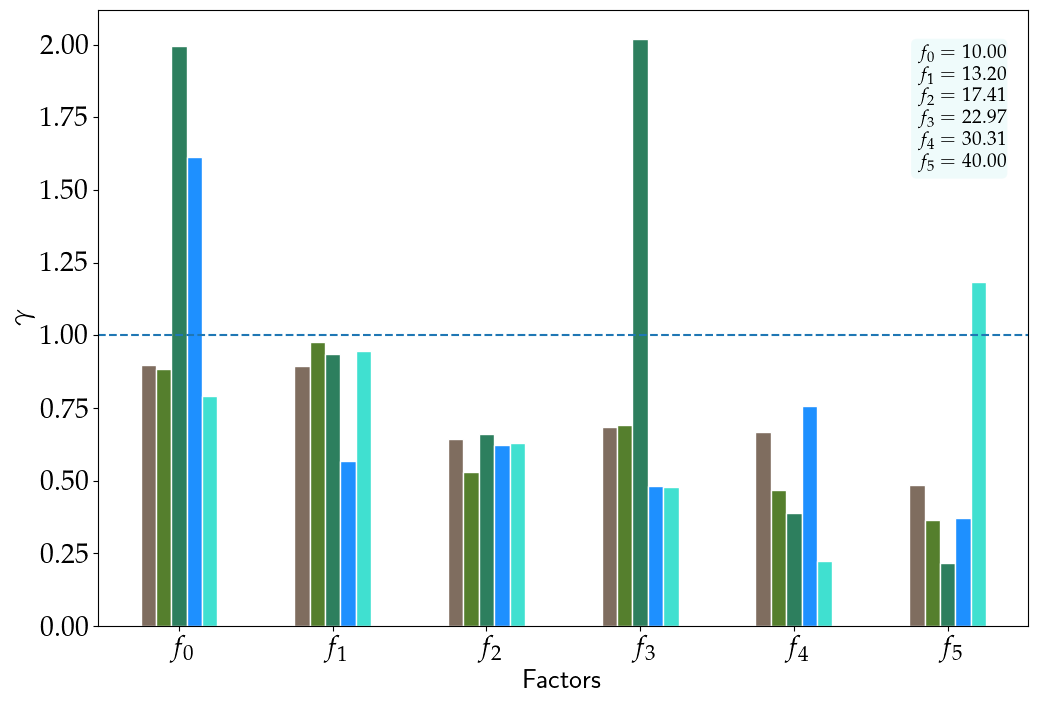

In [129]:
plt.figure(figsize = (12,8))
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white')
plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white')
plt.bar(r4, bars4, color='dodgerblue', width=barWidth, edgecolor='white')
plt.bar(r5, bars5, color='turquoise', width=barWidth, edgecolor='white')
plt.axhline(1, linestyle = '--')
plt.xlabel('group', fontweight='bold')
plt.xticks([r + 2.*barWidth for r in range(len(bars1))], [f'$f_{i}$' for i in range(len(factors))])
plt.ylabel(r'$\gamma$', fontsize = fontSize)
plt.xlabel(r'Factors', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.text(5.0, 2.0, textstr, fontsize=14, verticalalignment='top', bbox=props)
plt.show()

In [133]:
np.geomspace(1E-3, 1, 6)

NameError: name 'nnp' is not defined